# Initialize helper function

In [ ]:
def vonk2d(rseed,dx,dz,ax,az,ix,iz,pop,med,nu,vel,frac):

    if pop==1: # POP=GAUSSIAN
        D=3-nu
    elif pop==2: # POP=PDF
        D=3-nu/2

    nx=np.ceil(ix/dx);
    nz=np.ceil(iz/dz);

    if (nx/2) != np.round(nx/2):
        ddx=1
        nx=nx+ddx
    else:
        ddx=0

    if (nz/2) != np.round(nz/2):
        ddz=1
        nz=nz+ddz
    else:
        ddz=0

    # SPACEDOMAIN GRID
    x = np.linspace(1, int(nx), int(nx)) * dx
    z = np.linspace(1, int(nz), int(nz)) * dz

    # WAVENUMBER DOMAIN GRID
    dkx = 1/(nx*dx)
    dkz = 1/(nz*dz)
    [kx,kz] = np.meshgrid( 2*math.pi*dkx*np.linspace(int(-nx/2), int(nx/2-1), int(nx/2+nx/2-1 + 1)), 2*math.pi*dkz*np.linspace(int(-nz/2), int(nz/2-1), int(nz/2+nz/2-1 + 1)) )

    k=np.sqrt(kx**2 * ax**2 + kz**2 * az**2)

    if med==1:
    # Gaussian Chh
    # SQRT of the FOURIER TRANSROMF OF Gaussian CORR fkt.
        expcorr=((ax*az)/2) * np.exp( -(k**2) /2 )         # (Exact F(C_hh(x))
        expcorr=expcorr/np.amax(expcorr)                   # normalizing sqr(F(C_hh))
        expcorr=np.sqrt(expcorr)

    if med==2:
    # Exponential Chh
    # SQRT of the FOURIER TRANSROMF OF exp CORR fkt.
        expcorr=1/((1+k**2)**(1.5))                        # (Exact F(C_hh(x))
        expcorr=expcorr/np.amax(expcorr)                  # normalizing sqr(F(C_hh))
        expcorr=np.sqrt(expcorr);

    if med==3:
    # von Karman
    # SQRT of the FOURIER TRANSROMF OF vonk CORR fkt.
        expcorr=1/((1+k**2)**(nu+1));                      # (Exact F(C_hh(x))
        expcorr=expcorr/np.amax(expcorr);                  # normalizing sqr(F(C_hh))
        expcorr=np.sqrt(expcorr);                          #

    # DATA
    rng = np.random.default_rng(seed=rseed)
    data = rng.random([int(nz),int(nx)])

    # GOING TO FOURIER DOMAIN
    fdata = np.fft.fftshift(np.fft.fft2(data))

    # MULTIPLYING fdata by sqrt(C_hh)
    newfdata = fdata * expcorr

    # FROM FOURIER TO SPACE DOMAIN
    randdata = np.real(np.fft.ifft2(np.fft.fftshift(newfdata)))
    rdata = randdata;

    if pop==1:
    # scaling filed according to vel
        rdata=randdata * 2 * vel[0]
        data=data * 2 * vel[0]

    if pop==2:
        start = time.time()
        frac=np.cumsum(frac/np.sum(frac)) # normalize and cumsum
        sdata=np.sort(randdata.flatten())
        nn=nx*nz

        # Calculate critical values in randdata to resemble fraction
        fraclimit=np.zeros((len(frac)+1,1))
        fraclimit[0]=sdata[0]

        for n in range(len(frac)):
            fraclimit[n+1] = sdata[int(np.round(nn*frac[n]) - 1)]
        
        fraclimit[0] = fraclimit[0]- 0.1*np.abs(fraclimit[0])
        fraclimit[-1] = fraclimit[-1] + 0.1*np.abs(fraclimit[-1])

        rdata=np.zeros((np.size(randdata, 0), np.size(randdata, 1)))
        end = time.time()
        print("Time to finish section 1:", np.round(end-start, 5), "sec")
        
        '''
        start = time.time()
        for n in range(len(frac)):
            for r in range(rdata.shape[0]):
                for c in range(rdata.shape[1]):
                    mask = (randdata[r, c]>fraclimit[n]) and (randdata[r, c]<=fraclimit[n+1])
                    rdata[r, c] = rdata[r, c] + mask * vel[n]
        end = time.time()
        print("Time to finish section 2:", np.round(end-start, 5), "sec")
        '''
        
        rdata = randdata
    return rdata

# Load modules

In [1]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import copy

# Load data (previously generated) with simulation results

In [2]:
with open('_paper_dataGenerationMethodology_v5.npy', 'rb') as f:
    data = np.load(f)
    data2 = np.load(f)
    z_zone = np.load(f)
    x_zone_list = np.load(f)

# Create plot mask for the 'borders'

In [3]:
# Create 'borders' mask for the data to add dividing black lines for zones/subzones
my_cmap = copy.copy(plt.cm.get_cmap('gray')) # get a copy of the gray color map
my_cmap.set_bad(alpha=0) # set how the colormap handles 'bad' values

borders_zones = np.zeros(data[:, :600].shape)
for i, z in enumerate(z_zone[1:]):
    borders_zones[z-2:z+2, :] = 1
borders_zones[borders_zones == 0] = np.nan # insert 'bad' values into your lattice (the white)
    
borders_subzones = np.zeros(data[:, :600].shape)
for i, z in enumerate(z_zone[:-1]):
    borders_subzones[z-2:z+2, :] = 1
    for x in x_zone_list[i]:
        borders_subzones[z_zone[i]:z_zone[i+1]-1, x-2:x+2] = 1
borders_subzones[borders_subzones == 0] = np.nan # insert 'bad' values into your lattice (the white)

# Plot figure

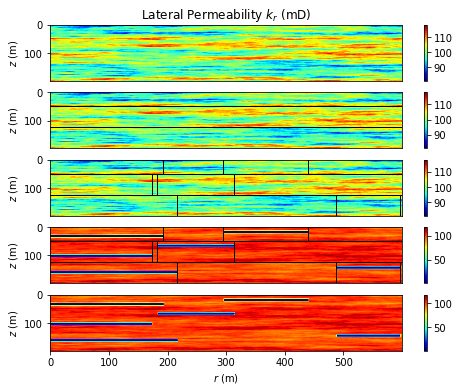

In [4]:
# Plot the generated map

fig = plt.figure(figsize=(8, 6))

plt.subplot(5, 1, 1)
plt.imshow(np.flipud(data[:, :600]))
plt.jet()
cbar = plt.colorbar(fraction=0.008)
plt.title('Lateral Permeability $k_r$ (mD)')
# plt.xlabel('$r$ (m)')
plt.xticks([])
plt.ylabel('$z$ (m)')
plt.yticks([0, 48], ["0", "100"])

plt.subplot(5, 1, 2)
plt.imshow(np.flipud(data[:, :600]))
plt.jet()
cbar = plt.colorbar(fraction=0.008)
# plt.xlabel('$r$ (m)')
plt.xticks([])
plt.ylabel('$z$ (m)')
plt.yticks([0, 48], ["0", "100"])
plt.imshow(np.flipud(borders_zones), cmap=my_cmap)

plt.subplot(5, 1, 3)
plt.imshow(np.flipud(data[:, :600]))
plt.jet()
cbar = plt.colorbar(fraction=0.008)
# plt.xlabel('$r$ (m)')
plt.xticks([])
plt.ylabel('$z$ (m)')
plt.yticks([0, 48], ["0", "100"])
plt.imshow(np.flipud(borders_subzones), cmap=my_cmap)

plt.subplot(5, 1, 4)
plt.imshow(np.flipud(data2[:, :600]))
plt.jet()
cbar = plt.colorbar(fraction=0.008)
plt.xticks([])
plt.ylabel('$z$ (m)')
plt.yticks([0, 48], ["0", "100"])
plt.imshow(np.flipud(borders_subzones), cmap=my_cmap)

plt.subplot(5, 1, 5)
plt.imshow(np.flipud(data2[:, :600]))
plt.jet()
cbar = plt.colorbar(fraction=0.008)
plt.xlabel('$r$ (m)')
plt.ylabel('$z$ (m)')
plt.yticks([0, 48], ["0", "100"])

# fig.savefig("_paper_dataGenerationMethodology_v6.png", dpi=300)
plt.show()